# HW2 PCA

Original jupyter notebook is uploaded at [GitHub](https://github.com/zhuo34/csmath2022).

First, prepare dataset.

Number of Train/Test images 3823/1797
Number of image '3' 389


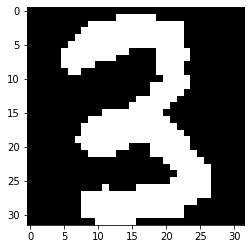

In [163]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os


class OptdigitsDataset:
    def __init__(self, root="."):
        if not os.path.exists(root):
            os.makedirs(root)
        train_filenames  = ["optdigits-orig.tra", "optdigits-orig.cv", "optdigits-orig.wdep"]
        test_filenames = ["optdigits-orig.windep"]
        self.x_train, self.y_train = self._load_files([os.path.join(root, n) for n in train_filenames])
        self.x_test, self.y_test = self._load_files([os.path.join(root, n) for n in test_filenames])
    
    @classmethod
    def _load_files(cls, files):
        if isinstance(files, str):
            files = [files]
        imgs, labels = [], []
        for file in files:
            x, y = cls._load_file(file)
            imgs.append(x)
            labels.append(y)
        x, y = np.vstack(imgs), np.hstack(labels)
        return x, y

    @classmethod
    def _load_file(cls, file):
        imgs, labels = [], []
        with open(file, "r") as f:
            for _ in range(21):
                s = f.readline()
            reading = False
            pixels = []
            while True:
                s = f.readline().strip()
                if not s:
                    break
                if len(s) == 32:
                    pixels.append([int(p) for p in s])
                else:
                    imgs.append(np.array(pixels).reshape(1, 32, 32))
                    labels.append(int(s))
                    pixels.clear()
        x, y = np.vstack(imgs), np.array(labels)
        return x, y


dataset = OptdigitsDataset("datasets/optdigits")
print(f"Number of Train/Test images {dataset.x_train.shape[0]}/{dataset.x_test.shape[0]}")

images3 = dataset.x_train[dataset.y_train==3]
print(f"Number of image '3' {images3.shape[0]}")
plt.imshow(images3[0])
plt.show()

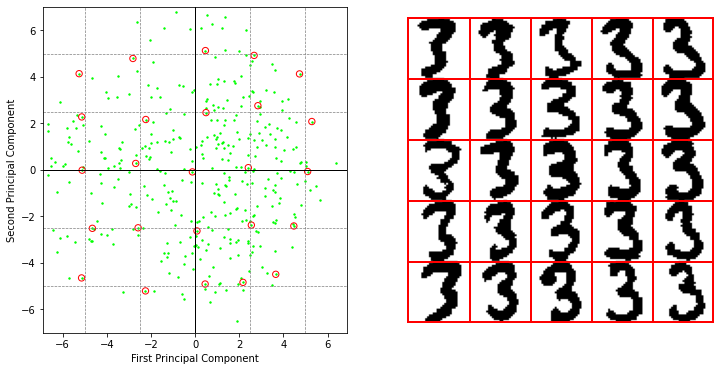

In [164]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components

    @classmethod
    def _stdarray(cls, X):
        if X.ndim == 1:
            X = X[np.newaxis, :]
        assert X.ndim == 2
        X = np.array(X, dtype=np.float64)
        return X
    
    def fit(self, X: np.ndarray): # X: [N, d]
        X = self._stdarray(X)
        self.m = np.mean(X, axis=0)
        X -= self.m[np.newaxis, :]
        V, self.S, self.Uh = np.linalg.svd(X, full_matrices=False)
        self.A = self.Uh[:self.n_components] # A: [p, d]

    def transform(self, X: np.ndarray): # X: [N, d]
        X = self._stdarray(X)
        return (X - self.m) @ self.A.T
    
    def fit_transform(self, X: np.ndarray): # X: [N, d]
        self.fit(X)
        return self.transform(X) # [N, p]

    def inverse_transform(self, X: np.ndarray): # X: [N, p]
        X = self._stdarray(X)
        return self.m + X @ self.A # [N, d]


X = images3.reshape([images3.shape[0], -1])
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X)

x_grid = [-5, -2.5, 0, 2.5, 5]
y_grid = [5, 2.5, 0, -2.5, -5]
img_ids = []
for y in y_grid:
    img_ids_row = []
    for x in x_grid:
        dis = np.sum((X_trans - np.array([x, y])) ** 2, axis=1)
        img_id = np.argmin(dis)
        img_ids_row.append(img_id)
    img_ids.append(img_ids_row)
img_ids = np.array(img_ids)

v_max, v_min = np.max(X_trans, axis=0), np.min(X_trans, axis=0)
xlim = np.min(np.abs([v_min[0], v_max[0]])) + 0.5
ylim = np.min(np.abs([v_min[1], v_max[1]])) + 0.5
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
xlim = ax[0].set_xlim(-xlim, xlim)
ylim = ax[0].set_ylim(-ylim, ylim)
ax[0].set_xlabel("First Principal Component")
ax[0].set_ylabel("Second Principal Component")
ax[0].scatter(X_trans[:, 0], X_trans[:, 1], c="#00ff00", s=2)
for x in x_grid:
    ax[0].plot([x, x], ylim, c="gray", ls="--", lw=0.7)
for y in y_grid:
    ax[0].plot(xlim, [y, y], c="gray", ls="--", lw=0.7)
ax[0].plot([0, 0], ylim, c="black", ls="-", lw=1)
ax[0].plot(xlim, [0, 0], c="black", ls="-", lw=1)
X_select = X_trans[img_ids.flatten()]
ax[0].scatter(X_select[:, 0], X_select[:, 1], edgecolors='r', marker='o', facecolors='none', s=40)

big_img = []
for id_row in img_ids:
    big_img_row = []
    for id in id_row:
        big_img_row.append(1 - images3[id])
    big_img.append(np.hstack(big_img_row))
big_img = np.vstack(big_img)
ax[1].set_xticks([])
ax[1].set_yticks([])
h, w = images3.shape[1:]
hlim = [0, img_ids.shape[0]*h]
wlim = [0, img_ids.shape[1]*w]
boarders = ["left", "right", "top", "bottom"]
for b in boarders:
    ax[1].spines[b].set_linewidth(2)
    ax[1].spines[b].set_color('r')
for x in range(1, img_ids.shape[1]):
    ax[1].plot([x*w, x*w], hlim, c="r", ls="-", lw=2)
for y in range(1, img_ids.shape[0]):
    ax[1].plot(wlim, [y*h, y*h], c="r", ls="-", lw=2)
ax[1].imshow(big_img)

plt.show()